<a href="https://colab.research.google.com/github/kwanda2426/projects/blob/main/regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries**

In [2]:
# Libraries for data loading, data manipulation and data visulisation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import plotly.express as px

from statsmodels.graphics.correlation import plot_corr
from scipy.stats import skew
from scipy.stats import kurtosis
import statistics
import missingno as msno

#Model training
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split



#ignoring warnings
import warnings
warnings.filterwarnings('ignore')

#making sure that we can see all rows and cols
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
from tabulate import tabulate


# **Importing Data**

In [3]:
# Reading data
file_path = "https://raw.githubusercontent.com/kwanda2426/projects/main/insurance.csv"
df = pd.read_csv(file_path)


In [4]:
# Showing first 5 lines of data
df.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
#data columns
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [6]:
# Rows and Columns of data
print('Data has {} rows and {} Columns'.format(df.shape[0],df.shape[1]))
print('')
print('Data has the following columns:')
for i in df.columns:
  print(i)

Data has 1338 rows and 7 Columns

Data has the following columns:
age
sex
bmi
children
smoker
region
charges


### Data Type of Columns

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Data set has no missing values, with a mixture of both categorical and numerical features.

## Describing the variables

In [8]:
#describing numerical columns
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [9]:
#describing categorical variables
cat_cols = df.select_dtypes(include=["object", "category"])
for i in cat_cols.columns:
  a = df[i].unique()
  print('unique categories for '+ i.upper() + ' is(are) :{}'.format(a))
  print('')


unique categories for SEX is(are) :['female' 'male']

unique categories for SMOKER is(are) :['yes' 'no']

unique categories for REGION is(are) :['southwest' 'southeast' 'northwest' 'northeast']



In [10]:
#Defining the variables
variables = {
    "Variable": ["age", "sex", "bmi", "children", "smoker", "region", "charges"],
    "Description": [
        "Age of the insured individual (between 18 and 64).",
        "Gender of the insured person (male or female).",
        "Body Mass Index, a measure of body fat based on height and weight (between 15 and 54).",
        "Number of dependent children covered by the insurance plan (between 0 and 5).",
        "Smoking status of the individual (yes or no).",
        "Residential area (northeast, northwest, southeast, southwest).",
        "Final insurance cost billed to the individual (between 1121 and 63770)."
    ]
}
# Create the DataFrame
var_desc = pd.DataFrame(variables)
var_desc.reset_index(drop=True, inplace=True)

# Display the DataFrame
print(tabulate(var_desc, headers='keys', tablefmt='pretty'))


+---+----------+----------------------------------------------------------------------------------------+
|   | Variable |                                      Description                                       |
+---+----------+----------------------------------------------------------------------------------------+
| 0 |   age    |                   Age of the insured individual (between 18 and 64).                   |
| 1 |   sex    |                     Gender of the insured person (male or female).                     |
| 2 |   bmi    | Body Mass Index, a measure of body fat based on height and weight (between 15 and 54). |
| 3 | children |     Number of dependent children covered by the insurance plan (between 0 and 5).      |
| 4 |  smoker  |                     Smoking status of the individual (yes or no).                      |
| 5 |  region  |             Residential area (northeast, northwest, southeast, southwest).             |
| 6 | charges  |        Final insurance cost b

The categorical variables will need to be encoded if they will be used in building the model.

## Exploratory Data Analysis

This method is meant to uncover the underlying structure of a data set and is important for a company because it exposes trends, patterns, and relationships that are not readily apparent.

## Correlation
This is meant to discover :
- Relationship between features and target variable.
- Multicollinearity - where features are highly correlated to each other. This guides whether to combine features or not as this means that features carry the same information.
- Most informative features. This helps to (simplify the model, reduce noise and improve predictive accuracy) by focusing on informative features only.
- Patterns such as if one feature increases, so does another OR One decreases , the other increases.


In [11]:
# Compute correlation matrix
corr_matrix = df.corr(numeric_only=True)

# Create heatmap
fig = px.imshow(
    corr_matrix,
    text_auto=True,
    color_continuous_scale='RdBu',
    zmin=-1, zmax=1,
    title='Feature Correlation Heatmap'
)

fig.update_layout(
    width=800,
    height=600,
    margin=dict(l=50, r=50, t=50, b=50)
)

fig.show()


## Feature Distibution
This is meant to discover :
- Relationship between features and target variable. This should help see if a feature that was not caught by correlation because of datatype(especially categorical) has a relationship with the target variable. This helps in encoding categorical features. For an example, with the region in our dataset. It could be that the feature does not affect charges at all, or some regions have more impact than others.

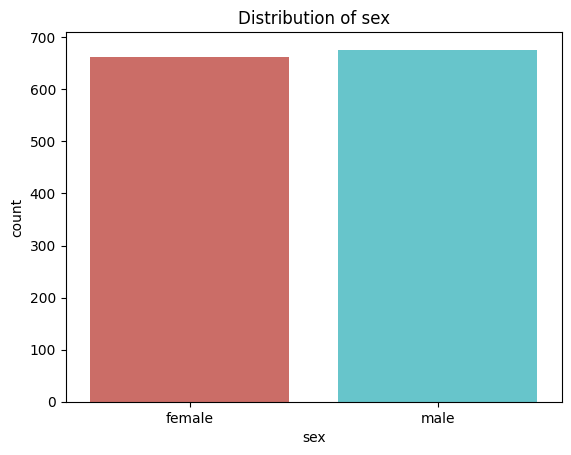

In [12]:
sns.countplot(x = 'sex', data = df, palette = "hls")
plt.title("Distribution of sex");



There's o

In [ ]:


plt.figure(figsize=(12,8))
sns.scatterplot(data = df_train, x="age", y="area_percentage", hue = "damage_grade", alpha=0.8, sizes=(40,200))
plt.title("Damage Grade vs. Area Percentage and Age")
plt.show()



In [ ]:
features = df_train.columns


df_train[features].hist(figsize = (25,20),  color = '#000354');

In [ ]:


fig, ax = plt.subplots(2, 3, figsize=(16, 8))

sns.countplot(x = 'default', data = df_train, hue = "term_deposit", palette = ['#4A4A4A','#ABABAB'], ax = ax[0,0])
sns.countplot(x = 'marital', data = df_train, hue = "term_deposit", palette =  ['#4A4A4A','#ABABAB'], ax = ax[0,1])
sns.countplot(x = 'education', data = df_train, hue = "term_deposit",palette =  ['#4A4A4A','#ABABAB'], ax = ax[0,2])
sns.countplot(x = 'contact', data = df_train, hue = "term_deposit", palette =  ['#4A4A4A','#ABABAB'], ax = ax[1,0])
sns.countplot(x = 'housing', data = df_train, hue = "term_deposit", palette =  ['#4A4A4A','#ABABAB'], ax = ax[1,1])
sns.countplot(x = 'loan', data = df_train, hue = "term_deposit",palette =  ['#4A4A4A','#ABABAB'], ax = ax[1,2])

